## MODULES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from scipy.stats import cauchy
from IPython.display import display, clear_output

## Functions and test

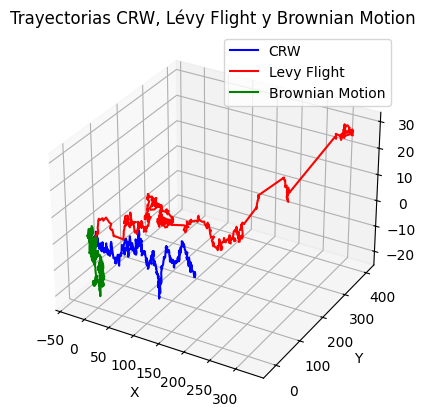

In [7]:

# Funciones para generar trayectorias
def generate_CRW(steps, speed, initial_position, cauchy_coef):
    angles = cauchy.rvs(0, cauchy_coef, size=steps)
    x = np.cos(angles) * speed
    y = np.sin(angles) * speed
    z = np.random.normal(0, speed, size=steps)  # Z con distribución normal
    changes = np.vstack([x, y, z]).T
    trajectory = np.cumsum(changes, axis=0) + initial_position
    return trajectory

def generate_LF(steps, speed, initial_position, cauchy_coef, alpha):
    distances = np.random.pareto(alpha, size=steps) + speed
    angles = cauchy.rvs(0, cauchy_coef, size=steps)
    x = np.cos(angles) * distances
    y = np.sin(angles) * distances
    z = np.random.normal(0, speed, size=steps)  # Z con distribución normal
    changes = np.vstack([x, y, z]).T
    trajectory = np.cumsum(changes, axis=0) + initial_position
    return trajectory

def generate_BM(steps, speed, initial_position):
    changes = np.random.normal(0, speed, size=(steps, 3))
    trajectory = np.cumsum(changes, axis=0) + initial_position
    return trajectory

# Parámetros comunes
steps = 500
speed = 1.0
initial_position = np.array([0, 0, 0])
cauchy_coef = 1.0
alpha = 1.5

# Generar trayectorias
trajectory_crw = generate_CRW(steps, speed, initial_position, cauchy_coef)
trajectory_lf = generate_LF(steps, speed, initial_position, cauchy_coef, alpha)
trajectory_bm = generate_BM(steps, speed, initial_position)

# Crear la gráfica en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar las trayectorias
ax.plot(trajectory_crw[:, 0], trajectory_crw[:, 1], trajectory_crw[:, 2], label='CRW', color='b')
ax.plot(trajectory_lf[:, 0], trajectory_lf[:, 1], trajectory_lf[:, 2], label='Levy Flight', color='r')
ax.plot(trajectory_bm[:, 0], trajectory_bm[:, 1], trajectory_bm[:, 2], label='Brownian Motion', color='g')

# Configuración del gráfico
ax.set_title('Trayectorias CRW, Lévy Flight y Brownian Motion')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Mostrar gráfico
plt.show()
